In [24]:
import sys
sys.path.insert(0, './../src/')
from MaskGenerator import MaskGenerator
from tensorflow import linalg, ones
import numpy as np
import matplotlib.pyplot as plt


In [25]:
 
def lookahead_mask(text):
    shape = len(text.split())
    mask = 1 - linalg.band_part(ones((shape, shape)), -1, 0)
    inverted_mask = 1 - mask
    int_list_of_lists = [
        [int(tensor.numpy()) for tensor in sublist] for sublist in inverted_mask
    ]

    return int_list_of_lists

In [26]:
mask_gen = MaskGenerator(False,False,False,'en')
input_sentence = "Apple is definitely looking at buying apples in U.K."
input_sentence_len = len(input_sentence.split())
matrix = np.ones((input_sentence_len, input_sentence_len))


2024-01-23 22:50:14.799 | INFO     | MaskGenerator:__init__:61 - Loaded <spacy.lang.en.English object at 0x0000028ACFFC9C40>


In [27]:
def plot_matrix_color(matrix):
    plt.imshow(matrix, cmap='viridis', interpolation='nearest')
    for i in range(len(matrix)):
        for j in range(len(matrix[0])):
            plt.text(j, i, str(matrix[i][j]), ha='center', va='center', color='r')

In [28]:
def plot_matrix(matrix):
    plt.imshow(matrix, cmap='gray', interpolation='nearest')
    for i in range(len(matrix)):
        for j in range(len(matrix[0])):
            plt.text(j, i, str(matrix[i][j]), ha='center', va='center', color='r')

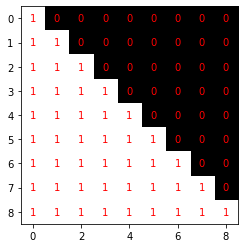

In [29]:
tensor = lookahead_mask(input_sentence)
plot_matrix(tensor)

2024-01-23 22:50:15.112 | INFO     | MaskGenerator:generate_mask:144 - Created empty mask with shape (9, 9)
2024-01-23 22:50:15.113 | DEBUG    | MaskGenerator:generate_mask:150 - Extracted tokens info:
[{'text': 'looking', 'pos': 'VERB', 'tag': 'VBG', 'position': 3, 'children': [{'text': 'Apple', 'pos': 'PROPN', 'tag': 'NNP', 'position': 0, 'children': []}, {'text': 'is', 'pos': 'AUX', 'tag': 'VBZ', 'position': 1, 'children': []}, {'text': 'definitely', 'pos': 'ADV', 'tag': 'RB', 'position': 2, 'children': []}, {'text': 'at', 'pos': 'ADP', 'tag': 'IN', 'position': 4, 'children': [{'text': 'buying', 'pos': 'VERB', 'tag': 'VBG', 'position': 5, 'children': [{'text': 'apples', 'pos': 'NOUN', 'tag': 'NNS', 'position': 6, 'children': []}, {'text': 'in', 'pos': 'ADP', 'tag': 'IN', 'position': 7, 'children': [{'text': 'U.K.', 'pos': 'PROPN', 'tag': 'NNP', 'position': 8, 'children': []}]}]}]}]}]
2024-01-23 22:50:15.113 | INFO     | MaskGenerator:generate_mask:153 - Mask filled for Apple is defi

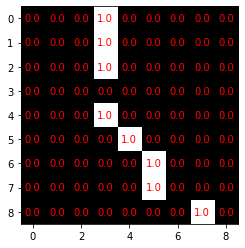

In [30]:
tensor = mask_gen.generate_mask(input_sentence)
plot_matrix(tensor)

In [31]:
def generate_stochastic_matrix(size):
    if size <= 0:
        raise ValueError("Rozmiar macierzy musi być większy niż 0")

    matrix = np.zeros((size, size))

    sums = np.ones((2, size))  # pierwszy wiersz to suma wierszy, drugi to suma kolumn 

    for i in range(size):
        if i!=size-1:
            matrix[i, i] = np.round(np.random.uniform(0.3, 0.55), 2)
            sums[0,i]-=matrix[i, i]
            sums[1][i]-=matrix[i,i]
        for j in range(size-1):
            if i==j:
                continue
            value = np.round(np.random.uniform(0.01, 0.5*np.min([sums[0][i], sums[1][j]])), 2)
            sums[0][i] -= value
            sums[1][j] -= value
            matrix[i, j] = value
        matrix[i][size-1] = np.round(sums[0][i],2)
    return matrix


In [32]:
def multiply_elementwise(matrix1, matrix2):
    result_matrix = [[0 for _ in range(len(matrix1[0]))] for _ in range(len(matrix1))]

    for i in range(len(matrix1)):
        for j in range(len(matrix1[0])):
            result_matrix[i][j] = matrix1[i][j] * matrix2[i][j]

    return result_matrix


2024-01-23 22:50:39.806 | INFO     | MaskGenerator:__init__:61 - Loaded <spacy.lang.en.English object at 0x0000028AD6BD0EE0>
2024-01-23 22:50:39.813 | INFO     | MaskGenerator:generate_mask:144 - Created empty mask with shape (9, 9)
2024-01-23 22:50:39.814 | DEBUG    | MaskGenerator:generate_mask:150 - Extracted tokens info:
[{'text': 'looking', 'pos': 'VERB', 'tag': 'VBG', 'position': 3, 'children': [{'text': 'Apple', 'pos': 'PROPN', 'tag': 'NNP', 'position': 0, 'children': []}, {'text': 'is', 'pos': 'AUX', 'tag': 'VBZ', 'position': 1, 'children': []}, {'text': 'definitely', 'pos': 'ADV', 'tag': 'RB', 'position': 2, 'children': []}, {'text': 'at', 'pos': 'ADP', 'tag': 'IN', 'position': 4, 'children': [{'text': 'buying', 'pos': 'VERB', 'tag': 'VBG', 'position': 5, 'children': [{'text': 'apples', 'pos': 'NOUN', 'tag': 'NNS', 'position': 6, 'children': []}, {'text': 'in', 'pos': 'ADP', 'tag': 'IN', 'position': 7, 'children': [{'text': 'U.K.', 'pos': 'PROPN', 'tag': 'NNP', 'position': 8, 

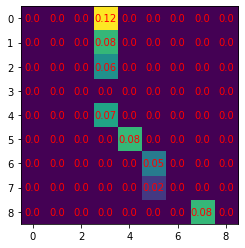

In [35]:
matrix1 =  MaskGenerator(False,False,False,'en').generate_mask(input_sentence)
matrix2 = generate_stochastic_matrix(input_sentence_len)
plot_matrix_color(multiply_elementwise(matrix1, matrix2))

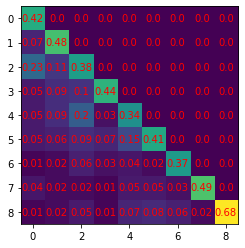

In [34]:
matrix1 =  lookahead_mask(input_sentence)
matrix2 = generate_stochastic_matrix(input_sentence_len)
plot_matrix_color( multiply_elementwise(matrix1, matrix2))